In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Point
import geoplot.crs as gcrs
import contextily as cx
from geopandas.tools import overlay
import mapclassify as mc
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Kept the original dataset
listingsNYC = pd.read_csv('listings.csv', dtype=object)
# Dropping all of the columns which we will not use
# listingsNYC= listingsNYC.drop(['last_review','license','latitude','longitude','host_name'], axis=1)

# Dropping all rows with any 'Nan' values in them
# listingsNYC.dropna(axis=0, how='any', inplace=True)
data_types_dict = {
    'price':'int64', 
    'minimum_nights':'int64', 
    'host_id':str,
    'number_of_reviews':'int64',
    'reviews_per_month':float,
    'calculated_host_listings_count':'int64',
    'availability_365':'int64',
    'number_of_reviews_ltm':'int64',
    'latitude':float,
    'longitude':float
}

#changing all the datatype to their respective types that we can work with
listingsNYC = listingsNYC.astype(data_types_dict)

# creating a price per stay (ppn) column with the price and minimim nights columns and rounding to 2 decimal places. 
# This is a float dtype 
listingsNYC['pps'] = (listingsNYC['price'] * listingsNYC['minimum_nights']).round(2)
listingsNYC['neighbourhood'].unique().shape[0]
listingsNYC.describe()
listingsNYC['annual_revenue'] = (365 - listingsNYC['availability_365']) *  listingsNYC['price']
listingsNYC = listingsNYC[(listingsNYC['price'] != 0)]
listingsNYC.loc[:,'log_price']=np.log(listingsNYC['price'])
listingsNYC.loc[:,'log_pps']=np.log(listingsNYC['pps'])
# listingsNYC['price_bin'] = pd.cut(listingsNYC['price'], bins=range(0, 111, 10), right=False, labels=range(0, 110, 10))
df = listingsNYC[(listingsNYC['price']<2000) & (listingsNYC['price']>20) & (listingsNYC['minimum_nights'] < 30)]
df['price_bin'] = pd.cut(df['price'], bins=range(0, 2001, 20), right=False, labels=range(0, 2000, 20))
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,pps,annual_revenue,log_price,log_pps,price_bin
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",7378,Rebecca,Brooklyn,Sunset Park,40.662650,-73.994540,Entire home/apt,275,...,0.03,1,267,1,NaN,5775,26950,5.616771,8.661294,260
1,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.803800,-73.967510,Private room,75,...,0.73,1,0,0,NaN,150,27375,4.317488,5.010635,60
3,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Midtown,40.764570,-73.983170,Private room,68,...,3.38,1,79,50,NaN,136,19448,4.219508,4.912655,60
6,5803,"Lovely Room 1 in BEST AREA; Legal Rental, Spot...",9744,Laurie,Brooklyn,South Slope,40.668010,-73.987840,Private room,124,...,1.31,3,163,14,NaN,496,25048,4.820282,6.206576,120
8,7097,Perfect for Your Parents: Privacy + Garden,17571,Jane,Brooklyn,Fort Greene,40.691233,-73.972702,Entire home/apt,220,...,2.01,2,38,36,NaN,660,71940,5.393628,6.492240,220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41525,772714221060214808,Good Vibes at The Bronx,421264574,Aridio,Bronx,Unionport,40.828074,-73.847886,Entire home/apt,125,...,NaN,1,60,0,NaN,250,38125,4.828314,5.521461,120
41526,772716724205003579,2 bedroom Condo near West Village,481177884,Steven,Manhattan,Chelsea,40.740030,-73.997302,Entire home/apt,1114,...,NaN,2,355,0,NaN,3342,11140,7.015712,8.114325,1100
41527,771961589340472067,Habitación Privada,409771624,Camila,Queens,Sunnyside,40.742223,-73.923310,Private room,124,...,NaN,1,360,0,NaN,248,620,4.820282,5.513429,120
41528,771962449581256963,Romántico y natural,421601513,Juan Carlos,Manhattan,Washington Heights,40.847271,-73.943419,Private room,80,...,NaN,3,358,0,NaN,400,560,4.382027,5.991465,80


In [3]:
neighborhood_counts = df.groupby('neighbourhood').count()
neighborhood_counts = neighborhood_counts[['id']]
neighborhood_counts.rename(columns={'id':'neighborhood_count'}, inplace=True)
neighborhood_means = df.groupby('neighbourhood').mean()
neighborhood_means = neighborhood_means[['latitude','longitude','price','annual_revenue']]
neighborhood_means_and_counts = pd.merge(neighborhood_counts,neighborhood_means, on='neighbourhood')
top_20_neighborhood_counts = neighborhood_means_and_counts.sort_values(by='neighborhood_count',ascending=False).head(20)
top_20_prices = neighborhood_means_and_counts.sort_values(by='price',ascending=False).head(20)
top_20_annual_revenue = neighborhood_means_and_counts.sort_values(by='annual_revenue',ascending=False).head(20)

In [4]:
nyc_map = gpd.read_file("neighbourhoods.geojson")
nyc_map_top_20_neighborhood_counts= nyc_map.merge(top_20_neighborhood_counts, on='neighbourhood', how='inner')
nyc_map_top_20_prices= nyc_map.merge(top_20_prices, on='neighbourhood', how='inner')
nyc_map_top_20_annual_revenue= nyc_map.merge(top_20_annual_revenue, on='neighbourhood', how='inner')
nyc_map_top_20_annual_revenue.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
nyc_map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
nyc_map_top_20_neighborhood_counts.to_crs(epsg=3857, inplace=True)
nyc_map_top_20_prices.to_crs(epsg=3857, inplace=True)
nyc_map_top_20_annual_revenue.to_crs(epsg=3857, inplace=True)

Text(0.5, 1.0, 'Average Number of Listings for the Top 20 Highest Priced Neighborhoods')

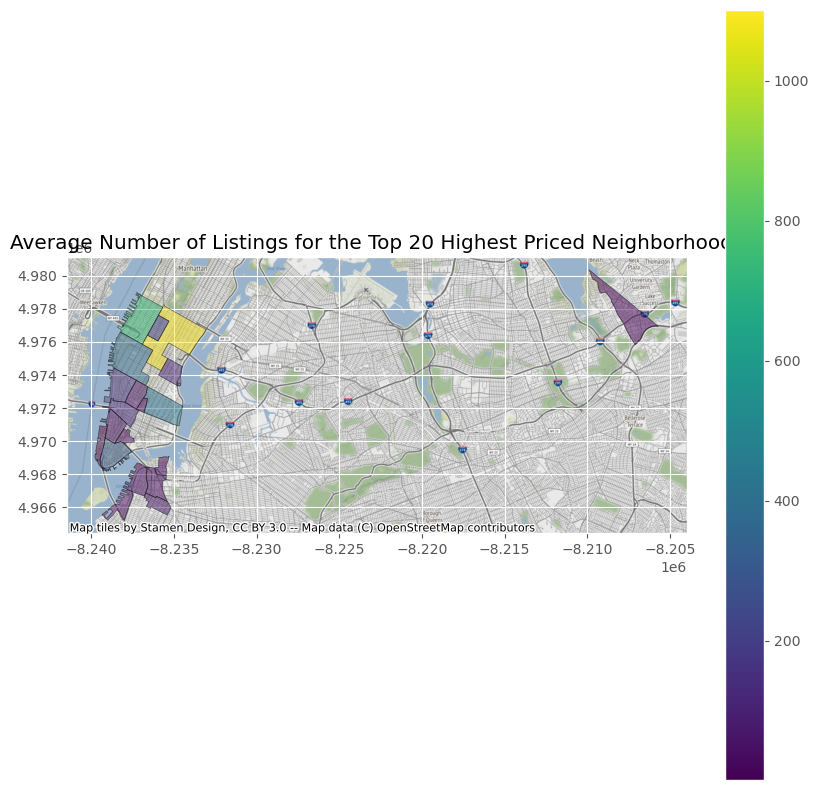

In [10]:
ax=nyc_map_top_20_annual_revenue.plot('neighborhood_count',figsize=(10, 10), alpha=0.5, edgecolor='k', legend=True)
cx.add_basemap(ax)
plt.title('Average Number of Listings for the Top 20 Highest Priced Neighborhoods')

Text(0.5, 1.0, 'Average Price for the Top 20 Highest Priced Neighborhoods')

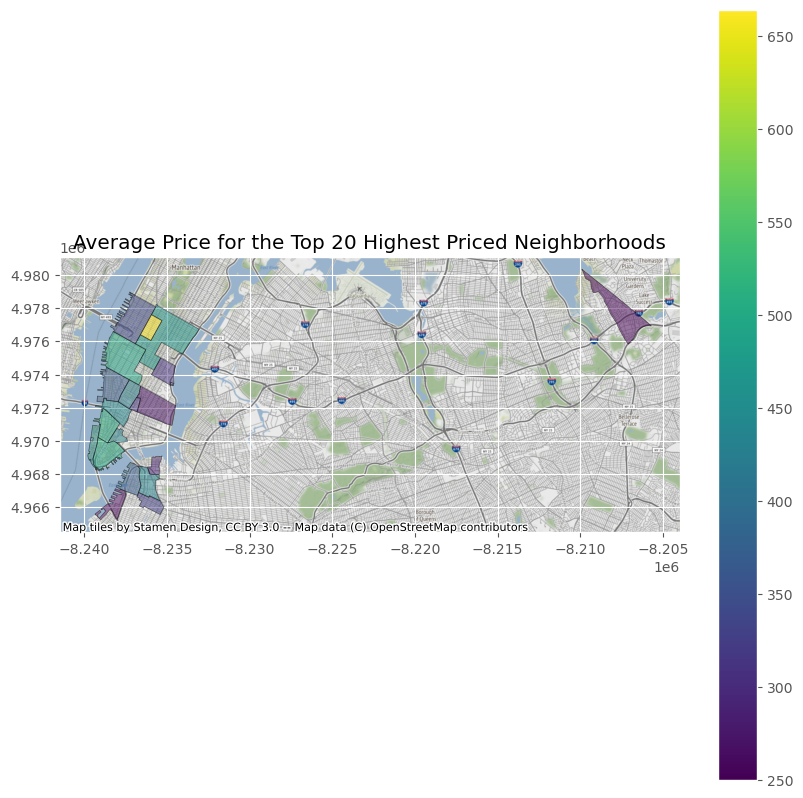

In [11]:
ax=nyc_map_top_20_annual_revenue.plot('price',figsize=(10, 10), alpha=0.5, edgecolor='k', legend=True)
cx.add_basemap(ax)
plt.title('Average Price for the Top 20 Highest Priced Neighborhoods')

Text(0.5, 1.0, 'Annual Revenue for the Top 20 Highest Priced Neighborhoods')

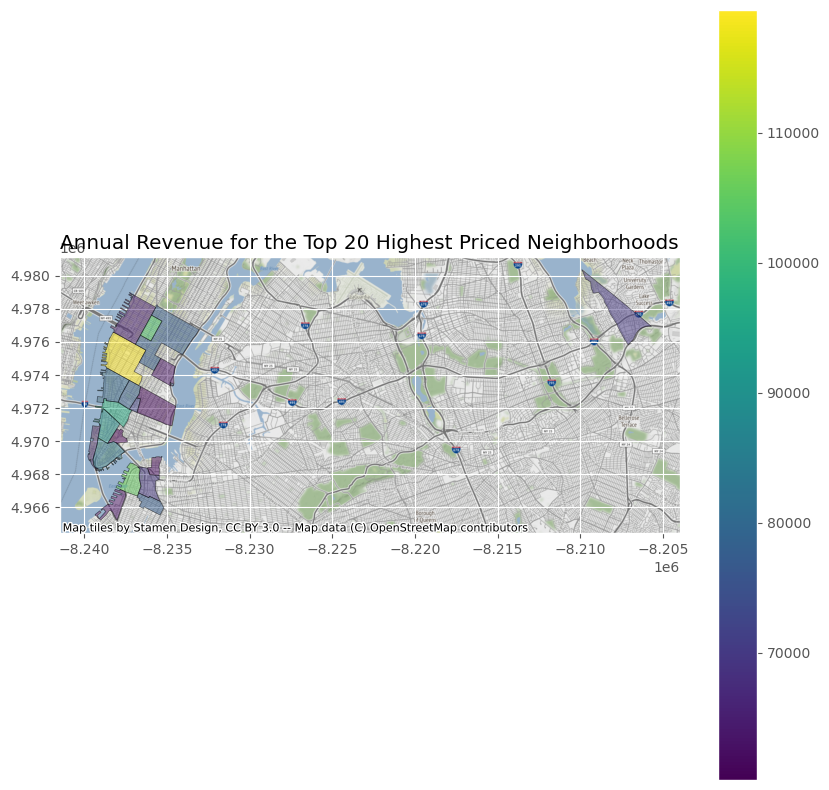

In [12]:
ax=nyc_map_top_20_annual_revenue.plot('annual_revenue',figsize=(10, 10), alpha=0.5, edgecolor='k', legend=True)
cx.add_basemap(ax)
plt.title('Annual Revenue for the Top 20 Highest Priced Neighborhoods')

In [13]:
nyc_map_top_20_neighborhood_counts_copy = nyc_map_top_20_neighborhood_counts.copy(deep=True)
nyc_map_top_20_prices_copy = nyc_map_top_20_prices.copy(deep=True)
nyc_map_top_20_annual_revenue_copy = nyc_map_top_20_annual_revenue.copy(deep=True)

geo_top_20_neighborhood_counts = gpd.GeoDataFrame(nyc_map_top_20_neighborhood_counts_copy,geometry = gpd.points_from_xy(nyc_map_top_20_neighborhood_counts_copy.longitude, nyc_map_top_20_neighborhood_counts_copy.latitude))
geo_top_20_prices = gpd.GeoDataFrame(nyc_map_top_20_prices_copy, geometry = gpd.points_from_xy(nyc_map_top_20_prices_copy.longitude, nyc_map_top_20_prices_copy.latitude))
geo_top_20_annual_revenue = gpd.GeoDataFrame(nyc_map_top_20_annual_revenue_copy, geometry = gpd.points_from_xy(nyc_map_top_20_annual_revenue_copy.longitude, nyc_map_top_20_annual_revenue_copy.latitude))

Text(0.5, 1.0, 'Most Expensive Neighborhoods and number of listings')

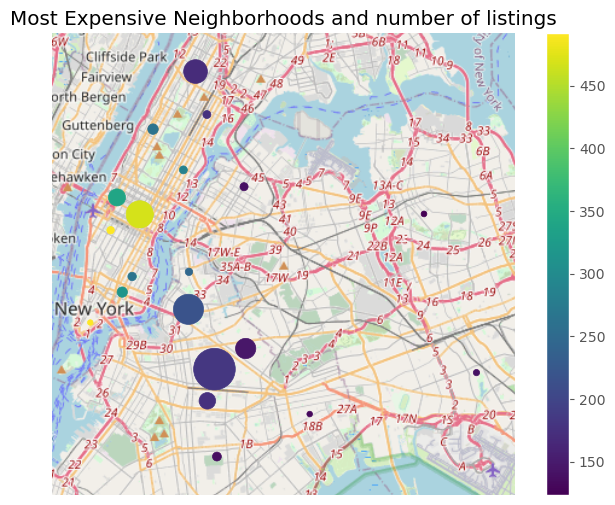

In [14]:
ax = gplt.webmap(nyc_map,projection=gcrs.WebMercator())
gplt.pointplot(
    geo_top_20_neighborhood_counts,
    hue='price',
    scale='neighborhood_count', limits=(4, 30),
    legend=True, legend_var='hue',
    ax=ax)
plt.title('Most Expensive Neighborhoods and number of listings')

Text(0.5, 1.0, 'Most Expensive Neighborhoods and number of listings')

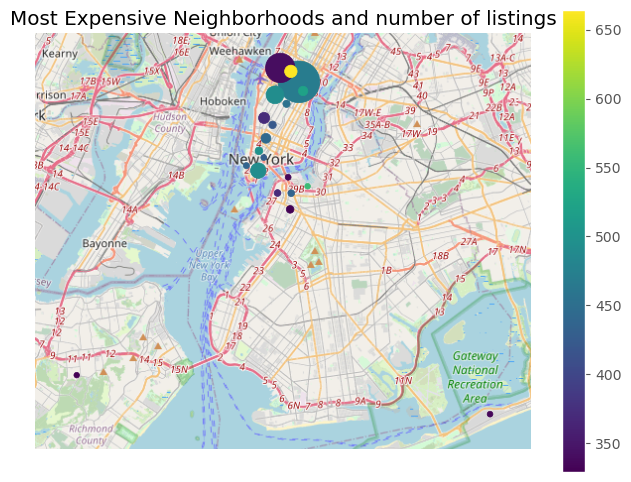

In [15]:
ax = gplt.webmap(nyc_map,projection=gcrs.WebMercator())
gplt.pointplot(
    geo_top_20_prices,
    hue='price',
    scale='neighborhood_count', limits=(4, 30),
    legend=True, legend_var='hue',
    ax=ax)
plt.title('Most Expensive Neighborhoods and number of listings')

Text(0.5, 1.0, 'Most Annual Revenue From Listings')

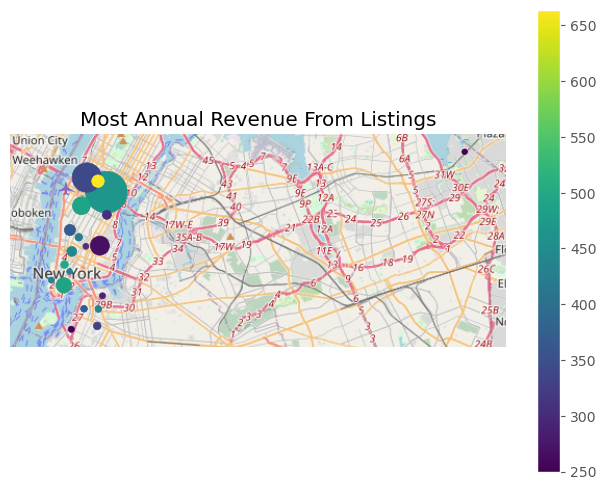

In [21]:
ax = gplt.webmap(nyc_map,projection=gcrs.WebMercator())
gplt.pointplot(
    geo_top_20_annual_revenue,
    hue='price',
    scale='neighborhood_count', limits=(4, 30),
    legend=True, legend_var='hue',
    ax=ax)
plt.title('Most Annual Revenue From Listings')